# Project 1: Final Project
## Handwriting generating with RNN


<p class="lead">
<a href="https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info">Creative Applications of Deep Learning with Google's Tensorflow</a><br />
<a href="http://pkmital.com">Parag K. Mital</a> / <a href="https://twitter.com/rndbrtrnd">Arnaud Bertrand</a><br />
<a href="https://www.kadenze.com">Kadenze, Inc.</a>
</p>

# Table of Contents

- [Overview](#overview)
- [Fetching the network](#fetching-network)
  - [Import from the checkpoint](#import-from-chekpoint)
  - [Network structure](#net-structure) 
  - [Generating some samples](#generating-samples)
- [From static to motion](#from-static-to-motion)
- [glyphs-rnn](#glyphs-rnn)

<a name="overview"></a>
# Overview

Few guidance is given for the project, especially compared to the sessions. This is good, since it pushes me to develop my creative skills. It could also be overwhelming, so I have decided to take few working assumptions.

The main one is to use a pre-designed net, and ideally even a pre-trained one, and to work around it. Designing an advanced NN requires a lot of effort, training it involves a lot of computing power (not mentioning the iterations). On the contrary, importing a net with the trained parameters is super easy. It has been done several times in the course, like with the Google inception v5 to generate deep dream pictures. Another assumption is to use a RNN. This architecture is incredibly powerful and has a high potential for generative art.

Before joining the course, I have been following the generative artist [Anders Hoff](https://twitter.com/inconvergent) for a couple of months, and I remember to have been amazed by the [Sand Glyphs](http://inconvergent.net/generative/sand-glyphs/) and the powerful effect of this asemic writing. Note that this algorithm is not based on neural nets. Then I have discovered [Hardmaru](https://twitter.com/hardmaru) by the impressive [large images generation from latent vectors](http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/). It happens that Hardmaru has implemented with TensorFlow a random handwriting generation based on the Alex Graves' [paper](http://arxiv.org/abs/1308.0850). Handwriting is highly personal, expressive and unique, so having an algorithm generating its own style is just AWESOME. It looks like a perfect playground for exploration.

The implementation of  Hardmaru is available on [GitHub](https://github.com/hardmaru/write-rnn-tensorflow). It was based on Python 2 and TensorFlow r0.5. The first step has been to upgrade to Python 3 and TensorFlow r0.11. Hardmaru has been nice enough to merge my push requests into the main repository. The network had to be trained again, but since there is no change of design, and I knew that the training would last a couple of hours on a CPU, it was OK.

**Note:** the content of this repository heavily relies on the Hardmaru' implementation of the random handwriting generation.

In [21]:
# Let's improt the usual tools
import tensorflow as tf
import matplotlib.pyplot as plt

import subprocess
import sys
import os
import pickle

%matplotlib inline

In [2]:
# Bit of formatting because I have good taste too:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="fetching-network"></a>
# Fetching the network

<a name="import-from-chekpoint"></a>
## Import from the checkpoint

As a prerequisite, clone locally ``write-rnn-tensorflow`` and update the static variable ``WRITE_RNN_DIR`` to the location of your clone. We will then import a module containing the network and some utils functions.

In [3]:
WRITE_RNN_DIR = '../../write-rnn-tensorflow'
sys.path.append(WRITE_RNN_DIR)

from model import Model
from utils import *

If everything runs fine, you can now import the neural net.

In [4]:
# Initiate TF
with open(os.path.join(WRITE_RNN_DIR, 'save', 'config.pkl'), 'rb') as f:
    saved_args = pickle.load(f)
tf.reset_default_graph()
model = Model(saved_args, True)
sess = tf.InteractiveSession()
saver = tf.train.Saver()

# Load the model
ckpt = tf.train.get_checkpoint_state(os.path.join(WRITE_RNN_DIR, 'save'))
saver.restore(sess, ckpt.model_checkpoint_path)

print("model loaded from: ", ckpt.model_checkpoint_path)
print("saved parameters: ", saved_args)

model loaded from:  ../../write-rnn-tensorflow/save/model.ckpt-11000
saved parameters:  Namespace(batch_size=1, data_scale=20, decay_rate=0.95, grad_clip=10.0, keep_prob=0.8, learning_rate=0.005, model='lstm', num_epochs=30, num_layers=2, num_mixture=20, rnn_size=256, save_every=500, seq_length=1)


<a name="net-structure"></a>
## Network structure

Let's have a look at the graph. As you can see, the architecture is a RNN based on LSTM cells. This network is reasonably complex. You can refer to the original blog post, [Handwriting Generation Demo in TensorFlow]() http://blog.otoro.net/2015/12/12/handwriting-generation-demo-in-tensorflow/) for all the details and rationals. To speak the truth, I didn't spend too much time on it. I would get back to it one day.

In [5]:
g = tf.get_default_graph()
names = [op.name for op in g.get_operations()]
print(names)

['Placeholder', 'Placeholder_1', 'pack', 'zeros/Const', 'zeros', 'rnnlm/output_w', 'rnnlm/output_w/Initializer/random_uniform/shape', 'rnnlm/output_w/Initializer/random_uniform/min', 'rnnlm/output_w/Initializer/random_uniform/max', 'rnnlm/output_w/Initializer/random_uniform/RandomUniform', 'rnnlm/output_w/Initializer/random_uniform/sub', 'rnnlm/output_w/Initializer/random_uniform/mul', 'rnnlm/output_w/Initializer/random_uniform', 'rnnlm/output_w/Assign', 'rnnlm/output_w/read', 'rnnlm/output_b', 'rnnlm/output_b/Initializer/random_uniform/shape', 'rnnlm/output_b/Initializer/random_uniform/min', 'rnnlm/output_b/Initializer/random_uniform/max', 'rnnlm/output_b/Initializer/random_uniform/RandomUniform', 'rnnlm/output_b/Initializer/random_uniform/sub', 'rnnlm/output_b/Initializer/random_uniform/mul', 'rnnlm/output_b/Initializer/random_uniform', 'rnnlm/output_b/Assign', 'rnnlm/output_b/read', 'split/split_dim', 'split', 'Squeeze', 'rnnlm_1/MultiRNNCell/Cell0/Slice/begin', 'rnnlm_1/MultiRNNCel

<a name="generating-samples"></a>
## Generating some samples

There is a convenient method in the ``model`` object to generate a sample. The statement below will generate a sample of length ``SAMPLE_LENGTH``. I will explain just after the meaning of outputs ``strokes`` and ``params``.

In [6]:
SVG_SCALE_FACTOR = 10
SAMPLE_LENGTH = 800
SAMPLE_FILENAME = 'sample-write-rnn'

[strokes, params] = model.sample(sess, SAMPLE_LENGTH)

The model may be complex, but it is very easy to use. The ``strokes`` numpy array is a list of coordinates, with an additional parameter for each coordinates to indicate if it is the beginning of a new stroke. The coordinates describe a path which is the handwritten line. This is that simple. The ``params`` are the parameters of a micture 2d gaussian.

In [7]:
print(strokes[10:20])
print(params[40][3])

[[ -2.905936     6.17589664   0.        ]
 [  1.94126153   1.87729836   0.        ]
 [ -0.12808786   0.53750771   1.        ]
 [-63.24012375 -66.92601013   0.        ]
 [ -1.54503369   0.08257494   0.        ]
 [  0.93807507  -0.25009182   0.        ]
 [  3.62708116  -1.7433269    0.        ]
 [ 10.64581299   0.52050048   0.        ]
 [ 20.09582329  -5.8627224    0.        ]
 [ 30.89101791  -4.319098     0.        ]]
[ 0.19552484  0.45388165  1.62778807  0.2335465   0.29068741  0.22656313
  0.39640376  2.96674633  0.25826833  0.71294165  0.18133742  1.96166277
  0.25744861  0.2150102   0.25077724  0.2352214   0.15710324  6.21955395
  0.1763498   0.29212153]


Hardmaru has built utils functions to display the ``strokes``. The first one renders simply the handwriting with a black color. The next one changes color at each new stroke, with a delightful effect. As you can see, the text is not intelligible, but it displays many artifacts of the latin handwriting, like the curls, letters with lower and upper parts and even sometimes words. I consider it as a [asemic writing](https://en.wikipedia.org/wiki/Asemic_writing), even if at the first look it could be consider as normal.

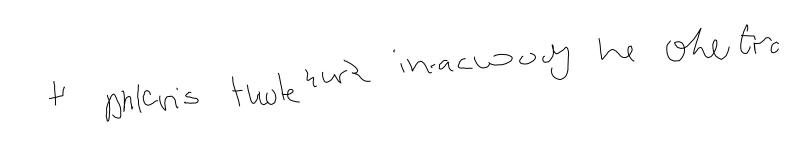

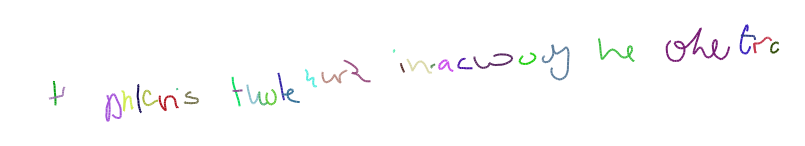

In [8]:
draw_strokes(strokes, factor=SVG_SCALE_FACTOR, svg_filename = SAMPLE_FILENAME+'.normal.svg')
draw_strokes_random_color(strokes, factor=SVG_SCALE_FACTOR, svg_filename = SAMPLE_FILENAME+'.color.svg')

Unfortunately there is no option to parametrize the output. You cannot input a string in this network like in the Alex Graves’ demo. Moreover, you may expect a kind of latent space here. Interesting thoughts for a next project.

<a name="from-static-to-motion"></a>
# From static to motion

In this part I will generate a gif to watch the network in action. Each frame will be a part of a step further in the overall path. I will also crop and move the center position along. I have created my own utils library to keep the code in the notebook more readable. 

In [9]:
from libs import utils, svg_utils

GIF_MARGIN = 25
GIF_STEP = 5
GIF_LENGTH = 800
GIF_FILENAME = 'write-rnn'
CONVERT_DENSITY = 400
TEMP_FILES = os.path.join('tmp', 'gif-frame-tmp')

if not os.path.exists('tmp'):
    os.mkdir('tmp')

Run the following statements until the RNN generates something fitting your taste.

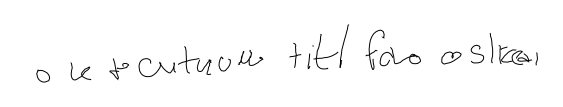

In [10]:
[strokes, _] = model.sample(sess, GIF_LENGTH)
draw_strokes(strokes, factor=SVG_SCALE_FACTOR, svg_filename = GIF_FILENAME+'.svg')

The text below will generate a ``.gif`` from the handwritting. Since the pace is not perfectly linear, you may have to adjust the parameters. For example, you can adapt the ``MARGIN`` parameter to add some buffer.

In [11]:
# Get size and frame
min_x, max_x, min_y, max_y = get_bounds(strokes, SVG_SCALE_FACTOR)
size_x = GIF_MARGIN * 2 + max_x - min_x
size_y = GIF_MARGIN * 2 + max_y - min_y
abs_x = GIF_MARGIN - min_x
abs_y = GIF_MARGIN - min_y

# Loop
imgs = []
for i in range(int(GIF_LENGTH * 4 / 100), len(strokes)):
    if (i % GIF_STEP) == 0:
        dwg = svg_utils.initiate(size_x, size_y, TEMP_FILES+'.svg')
        svg_utils.add_row_strokes(dwg, abs_x, abs_y, strokes[:i], SVG_SCALE_FACTOR)
        dwg.save()
        img = svg_utils.convert_to_img(TEMP_FILES+'.svg', TEMP_FILES+'.png', CONVERT_DENSITY)
        he, le, _ = img.shape
        pos = int((i / len(strokes)) * (le - he))
        print('frame:', i, 'position:', pos, '/', le)
        gif_frame = utils.img_crop(img, pos)
        imgs.append(gif_frame)

frame: 35 position: 111 / 3133
frame: 40 position: 126 / 3133
frame: 45 position: 142 / 3133
frame: 50 position: 158 / 3133
frame: 55 position: 174 / 3133
frame: 60 position: 190 / 3133
frame: 65 position: 206 / 3133
frame: 70 position: 222 / 3133
frame: 75 position: 238 / 3133
frame: 80 position: 253 / 3133
frame: 85 position: 269 / 3133
frame: 90 position: 285 / 3133
frame: 95 position: 301 / 3133
frame: 100 position: 317 / 3133
frame: 105 position: 333 / 3133
frame: 110 position: 349 / 3133
frame: 115 position: 364 / 3133
frame: 120 position: 380 / 3133
frame: 125 position: 396 / 3133
frame: 130 position: 412 / 3133
frame: 135 position: 428 / 3133
frame: 140 position: 444 / 3133
frame: 145 position: 460 / 3133
frame: 150 position: 476 / 3133
frame: 155 position: 491 / 3133
frame: 160 position: 507 / 3133
frame: 165 position: 523 / 3133
frame: 170 position: 539 / 3133
frame: 175 position: 555 / 3133
frame: 180 position: 571 / 3133
frame: 185 position: 587 / 3133
frame: 190 position: 

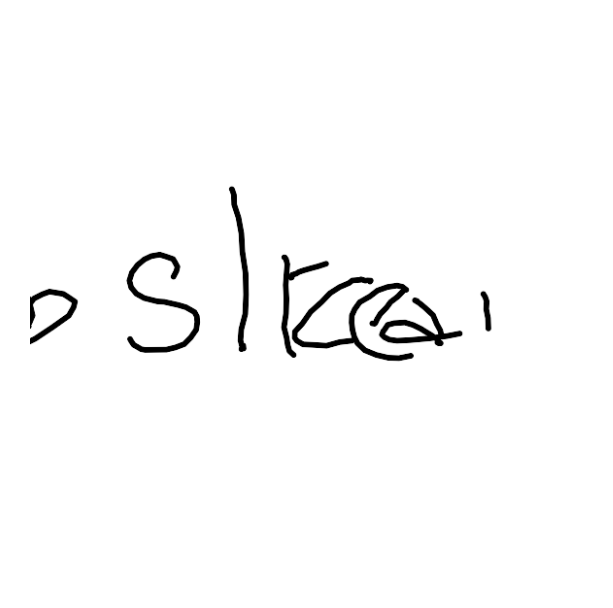

In [12]:
_ = utils.build_gif(imgs, interval=0.1, saveto=GIF_FILENAME+'.gif', show_gif=False)

<a name="glyphs-rnn"></a>
# glyphs-rnn

In this part, I will I make the RNN handwrite several lines with a layout similar to sand-glyphs. The parameters below can be adjusted to generate different setup.

In [47]:
SIZE = 1400
GLYPHS_MARGIN = 50
ROW_NUM = 12

SAMPLE_LENGTH = 1200
CONVERT_DENSITY_GLYPHS = 100

SVG_FILENAME = 'glyphs-rnn'

In [48]:
strokes_rows = []
for _ in range(ROW_NUM):
    [strokes, _] = model.sample(sess, SAMPLE_LENGTH)
    strokes_rows.append(strokes)

In [49]:
def print_strokes(data, stroke_width=3):
    spacing = (SIZE - 2 * GLYPHS_MARGIN) / ROW_NUM
    dwg = svg_utils.initiate(SIZE, SIZE, SVG_FILENAME+'.svg')
    for tup in enumerate(data):
        min_x, max_x, min_y, max_y = get_bounds(tup[1], SVG_SCALE_FACTOR)
        print('row:', tup[0], 'length:', max_x - min_x, 'height:', max_y - min_y)
        abs_x = GLYPHS_MARGIN - min_x 
        abs_y = GLYPHS_MARGIN + tup[0] * spacing - min_y
        svg_utils.add_row_strokes(dwg, abs_x, abs_y, tup[1], SVG_SCALE_FACTOR, stroke_width=stroke_width)
    dwg.save()
    img = svg_utils.convert_to_img(SVG_FILENAME+'.svg', SVG_FILENAME+'.png', CONVERT_DENSITY_GLYPHS)
    return img

row: 0 length: 1223.5490957092477 height: 98.02213013321163
row: 1 length: 1053.1555580589927 height: 63.33562055379153
row: 2 length: 845.5874030165378 height: 67.82371095344422
row: 3 length: 1065.0645412890233 height: 93.2655904706568
row: 4 length: 1229.1127389357525 height: 92.27191853867845
row: 5 length: 1033.6930862706147 height: 88.10791957117615
row: 6 length: 997.919023728568 height: 86.57923606745896
row: 7 length: 1057.8306403744016 height: 65.44614993113792
row: 8 length: 1046.2873709042556 height: 75.48592382632195
row: 9 length: 822.519425958209 height: 61.387126524001374
row: 10 length: 1432.764340714179 height: 85.56029500374572
row: 11 length: 1198.3982859104876 height: 113.7677013069391


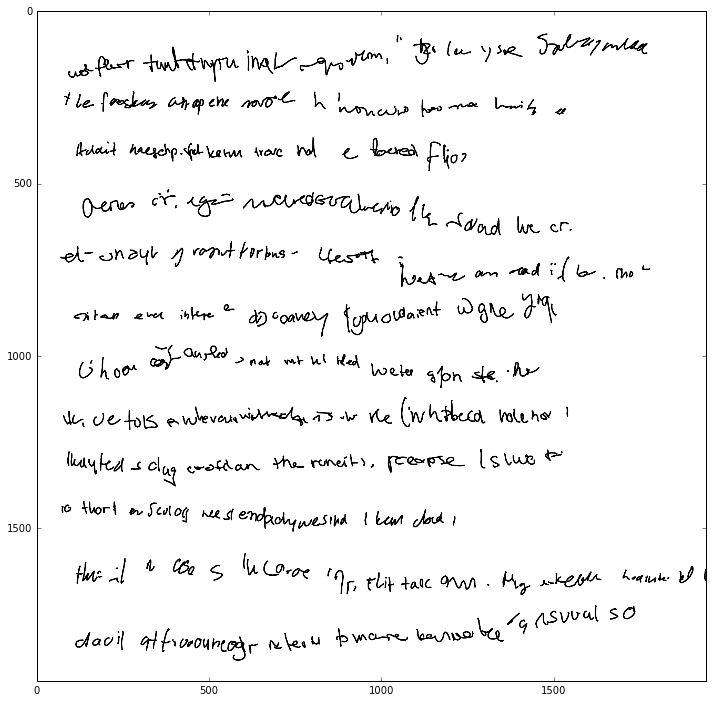

In [50]:
img = print_strokes(strokes_rows)
plt.figure(figsize=(12, 12))
plt.imshow(img)

In [55]:
MAX_LENGTH = 1200
MAX_HEIGHT = 80

In [56]:
strokes_rows = []
for _ in range(ROW_NUM):
    print('New row')
    while True:
        [strokes, _] = model.sample(sess, SAMPLE_LENGTH)
        min_x, max_x, min_y, max_y = get_bounds(strokes, SVG_SCALE_FACTOR)
        print(max_x - min_x, max_y - min_y)
        if max_x - min_x < MAX_LENGTH and max_y - min_y < MAX_HEIGHT:
            break
    strokes_rows.append(strokes)

New row
1360.0520288417317 158.42732791276634
1408.7200364028106 144.06423373376023
1019.9203008260595 87.71207635104658
1195.7394456536522 82.19374498445544
1182.610300161969 75.6826849885285
New row
1120.6773075172673 90.24442098708819
955.8440188836328 65.64332019556316
New row
959.8914817994815 59.32758086314418
New row
960.1056165411363 75.31451040245591
New row
987.7709445057433 70.22520177774128
New row
1297.4706195967708 106.07575902678069
1022.9559561403478 79.95893820486965
New row
1231.858609009021 103.34151365086434
885.1923873638262 71.71989614889027
New row
910.7648835121662 74.61530011792198
New row
1345.8121903229517 83.8873086645967
1223.5866594380907 104.32307244129487
772.6186652371674 77.85251700689551
New row
795.7299140261388 47.2144852387486
New row
963.3354114784734 53.409788993932295
New row
984.505743255233 103.32420405645976
931.7037037934186 83.96913415119049
1259.8658110988347 118.7930822610855
1165.5655603678897 84.39074835292993
1371.1827176786956 107.982

row: 0 length: 1182.610300161969 height: 75.6826849885285
row: 1 length: 955.8440188836328 height: 65.64332019556316
row: 2 length: 959.8914817994815 height: 59.32758086314418
row: 3 length: 960.1056165411363 height: 75.31451040245591
row: 4 length: 987.7709445057433 height: 70.22520177774128
row: 5 length: 1022.9559561403478 height: 79.95893820486965
row: 6 length: 885.1923873638262 height: 71.71989614889027
row: 7 length: 910.7648835121662 height: 74.61530011792198
row: 8 length: 772.6186652371674 height: 77.85251700689551
row: 9 length: 795.7299140261388 height: 47.2144852387486
row: 10 length: 963.3354114784734 height: 53.409788993932295
row: 11 length: 788.5349823594833 height: 60.14368516951798


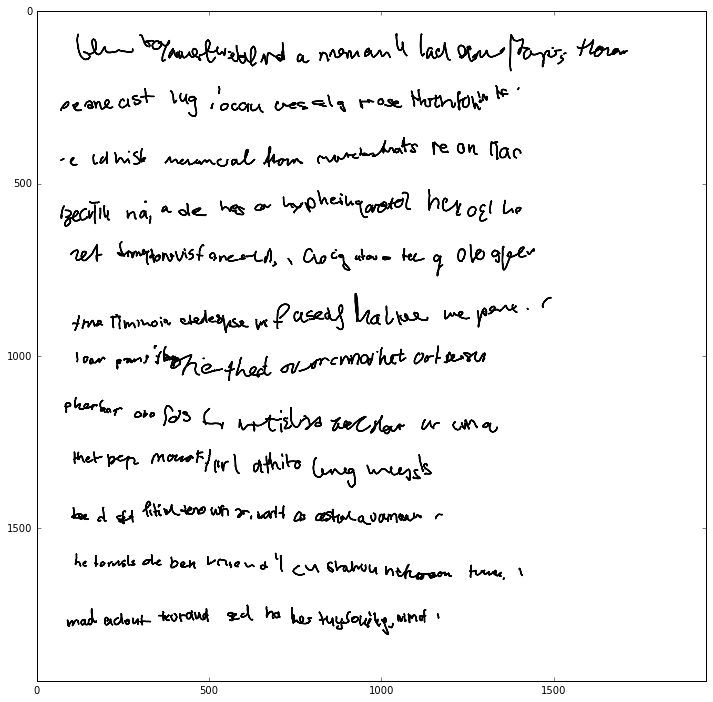

In [57]:
img = print_strokes(strokes_rows, 4)
plt.figure(figsize=(12, 12))
plt.imshow(img)